In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

# Not So Fancy Checkpoint - 2 Report

### Introduction
&ensp; It’s important for developers to measure the CPU usage. Existing methodology validation methods have been used to validate the CPU usage, including SBQ(Standards Base Qualification) and KBQ(Knowledge Base Qualification). However, these methods, using applications run one-by-one, failed to distinguish use cases applied in various conditions. For example, the CPU usage and associated wearout expectations would be different under the situation when the computer is in game’s mode and when it’s in an office mode. Further, the previous method KBQ can only be used in single tasking cases but ignores the influence from both foreground and background applications. A new method, UCBD(Use Case Based Design), is designed to achieve a better standardization for KBQ -- providing different minimum reliability requirements based on different working environments, namely, multitasking. We are interested in discovering how multitasking activities in CPUs affect battery life.  


### Process of our data collection

<ol>
    <li>run run.py data</li>
</ol>


&ensp; To begin data collecting process, we will open a new terminal and execute run.py file with paramter data. Firstly, The run.py will read paramters from data-params.json. By using these paramters, run.py execute go_battery.bat, This script file will use ERSV(Energy Checker SDK) to run my_battery.dll, which is a self-customized XLSDK Input Libray that collect Battery data. Then run.py execute go_processes.bat. This script file will use ERSV to run intel_process_input.dll, which is a Intel-provided XLSDK Input Libray that collect Processes data. Collected data will be stored as "processes/battery_output-00000X.db" files under src\data\Project\working_directory\input\ for further analysis.

#### Self-Implement Method Detail
&ensp; To collect power usage data from a battery, we implement my battery.dll,
which is a static standard input library. We choose static standard mode since
the number of features we collect doesn’t vary charging rate and they are syn-
chronous. My battery.dll can collect four features, Battery Lifetime, Max Bat-
tery Lifetime, AC/DC and Battery status. All features are indexed by times-
tamp. 
<br>
&ensp; Battery Lifetime, Max Battery Lifetime are used to calculate the power
usage. They are measured by expected remaining time with unit Second. For
batteries, Capacity (energy) equals power times time. Since max capacity re-
mains the same, comparing the max remaining time of ST and MT, we can
work out the power usage ratio between ST and MT. For the case that ST/MT
has very low word load and background application may have a big influence on
expected remaining time, we collect current battery lifetime T1 when ST/MT is
working and T2 when only background application is working. With equation
P1 = (T2 - T1)/T1 * P2, we can calculate power ratio between ST/MT and
background application.Since we can use processes IL to keep background application with constant
workload, then we can power ratio between ST and MT. 
<br>
&ensp; AC/DC and Battery Status are used to check if Battery life time are valid or not. When AC/DC is 1,
which means this computer uses AC battery, Battery life time will always return
-1. When Battery Status is 8, which means it is charging, Battery life time may
return extreme values since charging rate may exceed discharging rate. Since
we aim to probe how power usage varies between ST and MT, above cases will
cause error.

<AxesSubplot:>

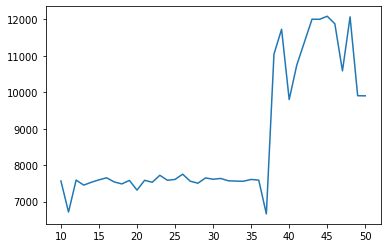

In [5]:
conn = sqlite3.connect('../src/data/Project/working_directory/input/battery_output-000002.db')
battery = pd.read_sql("select * from COUNTERS_ULL_TIME_DATA", conn)
battery = battery[battery["ID_INPUT"] == 6][["MEASUREMENT_TIME", "VALUE"]].rename(columns = {"VALUE": "EXPECTED REMAINING TIME"})
battery["EXPECTED REMAINING TIME"].drop([4,9]).iloc[:40].plot()

In [6]:
###mean of sampels before 37
T1 = np.mean(battery["EXPECTED REMAINING TIME"].drop([4,9])[:27])
###mean of sampels after 37
T2 = np.mean(battery["EXPECTED REMAINING TIME"].drop([4,9])[27:40])
print("P1 : P2 = 1 : " + str((T2 - T1) / T1)[:5])
print("ratio: " + str(T1 / (T2 - T1))[:5])

P1 : P2 = 1 : 0.432
ratio: 2.311


This is an example collected from my local computer. The samples before 37 are battery lifetime with ST( Dask with one core ) and The samples after 37 are battery lifetime with background application only. We can calculate ratio of power between P1 and P2 is 2.311

### Process of our EDA

<ol>
    <li>merge the raw databases using ATLSDK (Analyzer Task Library SDK)</li>
    <li>write SQL functions to generate data insights</li>
</ol>

#### Merge the raw databases

&ensp; After we collect data from both the battery usage and processes in the form of databases, we would merge them using both Analyzer Task Library (ATL) that  works  on  SDLite  DB  and  produces  on-device  analytics  and  ATLSDK,  a tool  to  develop,  debug,  and  optimize  the  ATL  for  Intel  telemetry collector. This  technique  is  also  called  edge  analytics  that allows us to correlate  data  col-lected by multiple ILs. 
<br>
&ensp; In our case, after consuming the two output databases (retrieved from the data collection process) as the two DB files shown below, the analyzer would produce the merged database which contains 9 pre-defined tables.

In [4]:
mycwd = os.getcwd()
os.chdir("..") #go to the previous dir
srcdir = os.getcwd()
print(os.getcwd())
print(os.listdir(srcdir + "\src\data\Project\working_directory\input"))

C:\Users\Yingyin\Documents\GitHub\Capstone-Project
['battery_output-000000.db', 'battery_output_consent_history-000001-000000.json', 'processes_output-000000.db', 'processes_output_consent_history-000001-000000.json']


In [5]:
os.chdir(mycwd) #go back to where I come from

In [8]:
os.chdir("..") #go to the previous dir
outputPath = os.getcwd() + "\\src\\data\\Project\\working_directory\\output" # the outputPath is the path to the merged database
DBName = "IDC_DATABASE.SQLITE"
conn = sqlite3.connect(outputPath+"\\"+DBName)
c = conn.cursor()

Here is the 9 pre-defined table from the merged database.

In [13]:
for x in (c.execute("select name from sqlite_master where type = 'table';")):
    print(x)

('INPUT_LIBRARIES',)
('INPUTS',)
('COUNTERS_BLOB_TIME_DATA',)
('COUNTERS_DOUBLE_TIME_DATA',)
('COUNTERS_LL_TIME_DATA',)
('COUNTERS_STRING_TIME_DATA',)
('COUNTERS_ULL_TIME_DATA',)
('COUNTERS_UUID_TIME_DATA',)
('DB_META_DATA',)
('tbl1',)


&ensp; DB\_META\_DATABASE contains data collection beginning and end times, INPUT\_LIBRARIES shows the input libraries (IL) collected, and INPUT describes all metrics in the input libraries. COUNTERS\_BLOB\_TIME\_DATA table contains binary large objects, as the name suggested. Tables that start with “COUNTERS” all have the five attributes: 
<br>
<ol>
    <li>MEASUREMENT\_TIME (timestamp of the value collected)</li>
    <li>ID\_INPUT (unique ID for each session)</li>
    <li>VALUE (value corresponding to the metrics)</li>
    <li>PRIVATE\_DATA (per each input metric attribute)</li>
    <li>SESSION\_ID (number ID for each raw database)</li>
<br>
&ensp; Below is an example.

In [20]:
for x in (c.execute("select * from COUNTERS_DOUBLE_TIME_DATA limit 5;")):
    print(x)

('2020-11-20 14:26:57.900', 1, 0.0, '136', 2)
('2020-11-20 14:26:57.900', 2, 0.0, '136', 2)
('2020-11-20 14:26:57.902', 1, 0.0, '2208', 2)
('2020-11-20 14:26:57.902', 2, 0.0, '2208', 2)
('2020-11-20 14:26:57.902', 1, 315.265625, '0', 2)


&ensp; By taking advantage of the primary key SESSION\_ID in all the tables, we are able to merge the interrelated tables and examine the relationship among them. For example, we can get all the input descriptions by joining INPUT and INPUT\_LIBRARIES on the SESSION\_ID.

In [22]:
# Here, tbl1 already created in EDA.ipynb, is a table from joining INPUT and INPUT_LIBRARIES on identical session ID.
columns = {}
for x in (c.execute("PRAGMA table_info(tbl1)")):
    columns[x[1]] = x[2]

In [23]:
df = pd.DataFrame(columns = columns.keys())
counter = 0
for x in c.execute("SELECT * FROM tbl1"):
    df.loc[counter] = x
    counter += 1
df.head()

,ID_INPUT,ID_INPUT_LIBRARY,ID_BLOB_INPUT,INDEX_IN_BLOB,INPUT_NAME,INPUT_DESCRIPTION,INPUT_TYPE,INPUT_CATALOG_TIME_UTC,GUID,SESSION_ID,ID_INPUT_LIBRARY:1,NAME,FILE_NAME,VERSION,GUID:1,LOAD_TIME_UTC,UNLOAD_TIME_UTC,DYNAMIC,SESSION_ID:1
0,0,0,0,0,BATTERY(0),Battery:::AC/DC::,1,2020-11-20 06:25:12.002,547f73d8-d0fe-478c-b822-69d88ed1a2f9,1000,0,BATTERY,C:\Users\Yingyin\Documents\GitHub\Capstone-Pro...,1.1.0.327,500e2ee8-c38f-4306-9e4a-88608ec5fc5d,2020-11-20 06:25:11.000,0000-00-00 00:00:00.000,0,1000
1,1,0,0,0,BATTERY(1),Battery:::BatteryLifeTime:Sec:,1,2020-11-20 06:25:12.003,b92cc7d8-6c93-4fb6-858f-5bfbac1a3e75,1000,0,BATTERY,C:\Users\Yingyin\Documents\GitHub\Capstone-Pro...,1.1.0.327,500e2ee8-c38f-4306-9e4a-88608ec5fc5d,2020-11-20 06:25:11.000,0000-00-00 00:00:00.000,0,1000
2,2,0,0,0,BATTERY(2),Battery:::MaxBatteryLifeTime:Sec:,1,2020-11-20 06:25:12.003,e571a62b-f92d-4d17-ab8f-cf0dfa21e59c,1000,0,BATTERY,C:\Users\Yingyin\Documents\GitHub\Capstone-Pro...,1.1.0.327,500e2ee8-c38f-4306-9e4a-88608ec5fc5d,2020-11-20 06:25:11.000,0000-00-00 00:00:00.000,0,1000
3,0,0,0,0,PROCESS(0),OS::PROCESS:EXECNAME::,4,2020-11-20 06:26:57.901,ee7de8db-96fe-483b-8391-3ad4fffe5473,2,0,PROCESS,C:\Users\Yingyin\Documents\GitHub\Capstone-Pro...,1.1.0.327,fcef3fe0-c8ff-4f35-a7f0-5bbdc857e8ad,2020-11-20 06:26:15.000,0000-00-00 00:00:00.000,0,2
4,1,0,0,0,PROCESS(1),OS::PROCESS:KERNEL:SECS:,3,2020-11-20 06:26:57.901,d296755d-c52d-4302-b69c-03f097080c11,2,0,PROCESS,C:\Users\Yingyin\Documents\GitHub\Capstone-Pro...,1.1.0.327,fcef3fe0-c8ff-4f35-a7f0-5bbdc857e8ad,2020-11-20 06:26:15.000,0000-00-00 00:00:00.000,0,2


In [24]:
#drop repetitive columns
df = df.drop(columns = ['ID_INPUT_LIBRARY:1', 'SESSION_ID:1'], axis =1)
df.dtypes

ID_INPUT                  object
ID_INPUT_LIBRARY          object
ID_BLOB_INPUT             object
INDEX_IN_BLOB             object
INPUT_NAME                object
INPUT_DESCRIPTION         object
INPUT_TYPE                object
INPUT_CATALOG_TIME_UTC    object
GUID                      object
SESSION_ID                object
NAME                      object
FILE_NAME                 object
VERSION                   object
GUID:1                    object
LOAD_TIME_UTC             object
UNLOAD_TIME_UTC           object
DYNAMIC                   object
dtype: object

We need to convert the data types for numerical columns later as we go along.

In [25]:
df.NAME.value_counts()

PROCESS    17
BATTERY     3
Name: NAME, dtype: int64

We have 17 input libraries for process and 3 for battery. Let's see what they are.

In [27]:
df.INPUT_DESCRIPTION

0                         Battery:::AC/DC::
1            Battery:::BatteryLifeTime:Sec:
2         Battery:::MaxBatteryLifeTime:Sec:
3                    OS::PROCESS:EXECNAME::
4                  OS::PROCESS:KERNEL:SECS:
5                    OS::PROCESS:USER:SECS:
6         OS:ETW:PROCESS:DISKIO_READ:BYTES:
7        OS:ETW:PROCESS:DISKIO_WRITE:BYTES:
8          OS:ETW:PROCESS:TCPIP_SEND:BYTES:
9                  OS::PROCESS:START_TIME::
10             OS::PROCESS:RUNNING_TIME:MS:
11                   OS::PROCESS:FILENAME::
12                    OS::PROCESS:VERSION::
13                OS::PROCESS:IOREAD:BYTES:
14               OS::PROCESS:IOWRITE:BYTES:
15               OS::PROCESS:IOOTHER:BYTES:
16                 OS::PROCESS:PAGEFAULTS::
17         OS:ETW:PROCESS:HARD_PAGEFAULTS::
18         OS::PROCESS:WORKSET_SIZE:KBYTES:
19    OS::PROCESS:PEAK_WORKSET_SIZE:KBYTES:
Name: INPUT_DESCRIPTION, dtype: object

From the descriptions, we have multiple features of battery's and process's usage, which are great factors to help us explore minimum reliability requirements under ST and MT cases.

### Conclusions and Ideas
<br>
&ensp; Earlier we demonstrated an interest in exploring minimum reliability requirements from a ST (single-tasking) activity and a MT (multitasking) activity. The way we collected the data as we described above could help us achieve the goal efficiently: by collecting the data twice, one under a ST activity, that is to say, one process only, and the other one under a MT activity, multiple processes, we would merge the raw databases and get two merged databases for both situations. Intuitively, batteries are more enduring in ST than in MT, which could be validated with the inputs, such as the Battery::BatteryLifeTime::Sec. Further, to explore minimum reliability requirements for both ST and MT, we could use the same set of data to see with what number amount of workload, or what range, would be suitable, by performing a cluster analysis on the chosen inputs, including the remaining amount of battery, number of processes, etc..